In [1]:
import sys
sys.path.append('/Volumes/SANDISK128/Documents/Thesis/Python/')
#sys.path.append('/Volumes/SANDISK128/Documents/Thesis/Python/weather_mast/')
#sys.path.append('/Volumes/SANDISK128/Documents/Thesis/Python/Retrieval/')
sys.path.append('/Volumes/SANDISK128/Documents/Thesis/Python/Retrieval_MEPS/')
import netCDF4
import fill_values as fv
import datetime
import calc_date as cd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import save_fig as sF
import createFolder as cF
from matplotlib.gridspec import GridSpec
import plt_ce_image as im
#import read_MRR as pMRR
import plot_sfc_spaghetti_ret as spagh


#from scipy.integrate import simps
import matplotlib as mpl

In [2]:
year = '2016'
month = '12'
#t = ['17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27']
t = ['20', '21', '22', '23', '24', '25', '26', '27']
tid = '00'
station = 'Haukeliseter'


### Figures 
savefig = 0
figdir = '../../Figures/MEPS/vert_SWC_EM09/_48'
cF.createFolder('%s/' %(figdir))
form = 'png'
################################################################
### MEPS
level = 'sfc'
nc_dir_sfc = '../../Data/MEPS/%s/%s_%s' %(station,level,tid)
level = 'ml'
nc_dir_ml = '../../Data/MEPS/%s/%s_%s' %(station,level,tid)
# air temperature
var_name_air_temp = 'air_temperature_ml'
air_temp_dir = '%s/%s' %(nc_dir_ml,var_name_air_temp)
# snow fall amount
var_name_snow = 'snowfall_amount_ml'
snow_dir = '%s/%s' %(nc_dir_ml,var_name_snow)
# graupel fall amount
var_name_graupel = 'graupelfall_amount_ml'
graupel_dir = '%s/%s' %(nc_dir_ml,var_name_graupel)
# atmosphere_cloud_ice_content_ml
var_name_cl_ice = 'atmosphere_cloud_ice_content_ml'
cl_ice_dir = '%s/%s' %(nc_dir_ml,var_name_cl_ice)



In [3]:
air_temp_file     = dict()
snow_file         = dict()
graupel_file      = dict()
cl_ice_file       = dict()

fn_air_temp       = dict()
fn_snow           = dict()
fn_graupel        = dict()
fn_cl_ice         = dict()

time_ml           = dict()
air_temp_ml       = dict()
pressure_ml       = dict()
snow_amount_ml    = dict()
graupel_amount_ml = dict()
cl_ice_ml         = dict()

thickness_ml      = dict()
ice_amount_ml     = dict()
time              = dict()
height_ml         = dict()
height            = dict()
density_ml        = dict()
SWP_model         = dict()

In [4]:
Rd = 287.    # gas constant for dry air [J kg^-1 K^-1]

In [5]:
# layer for average snow water content within 200 m
nlay= 15
bot = []
top = []
for k in range(0, nlay):
    bot.append(100.+ k*200)
    top.append(bot[k]+200)

avg_SWC_ml = dict()
h_avg      = dict()
t_avg      = dict()

/Volumes/SANDISK128/Applications/anaconda/envs/py36ECMWF/lib/python3.6/site-packages/ipykernel_launcher.py:89: RuntimeWarning: invalid value encountered in greater_equal
/Volumes/SANDISK128/Applications/anaconda/envs/py36ECMWF/lib/python3.6/site-packages/ipykernel_launcher.py:89: RuntimeWarning: invalid value encountered in less
/Volumes/SANDISK128/Applications/anaconda/envs/py36ECMWF/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


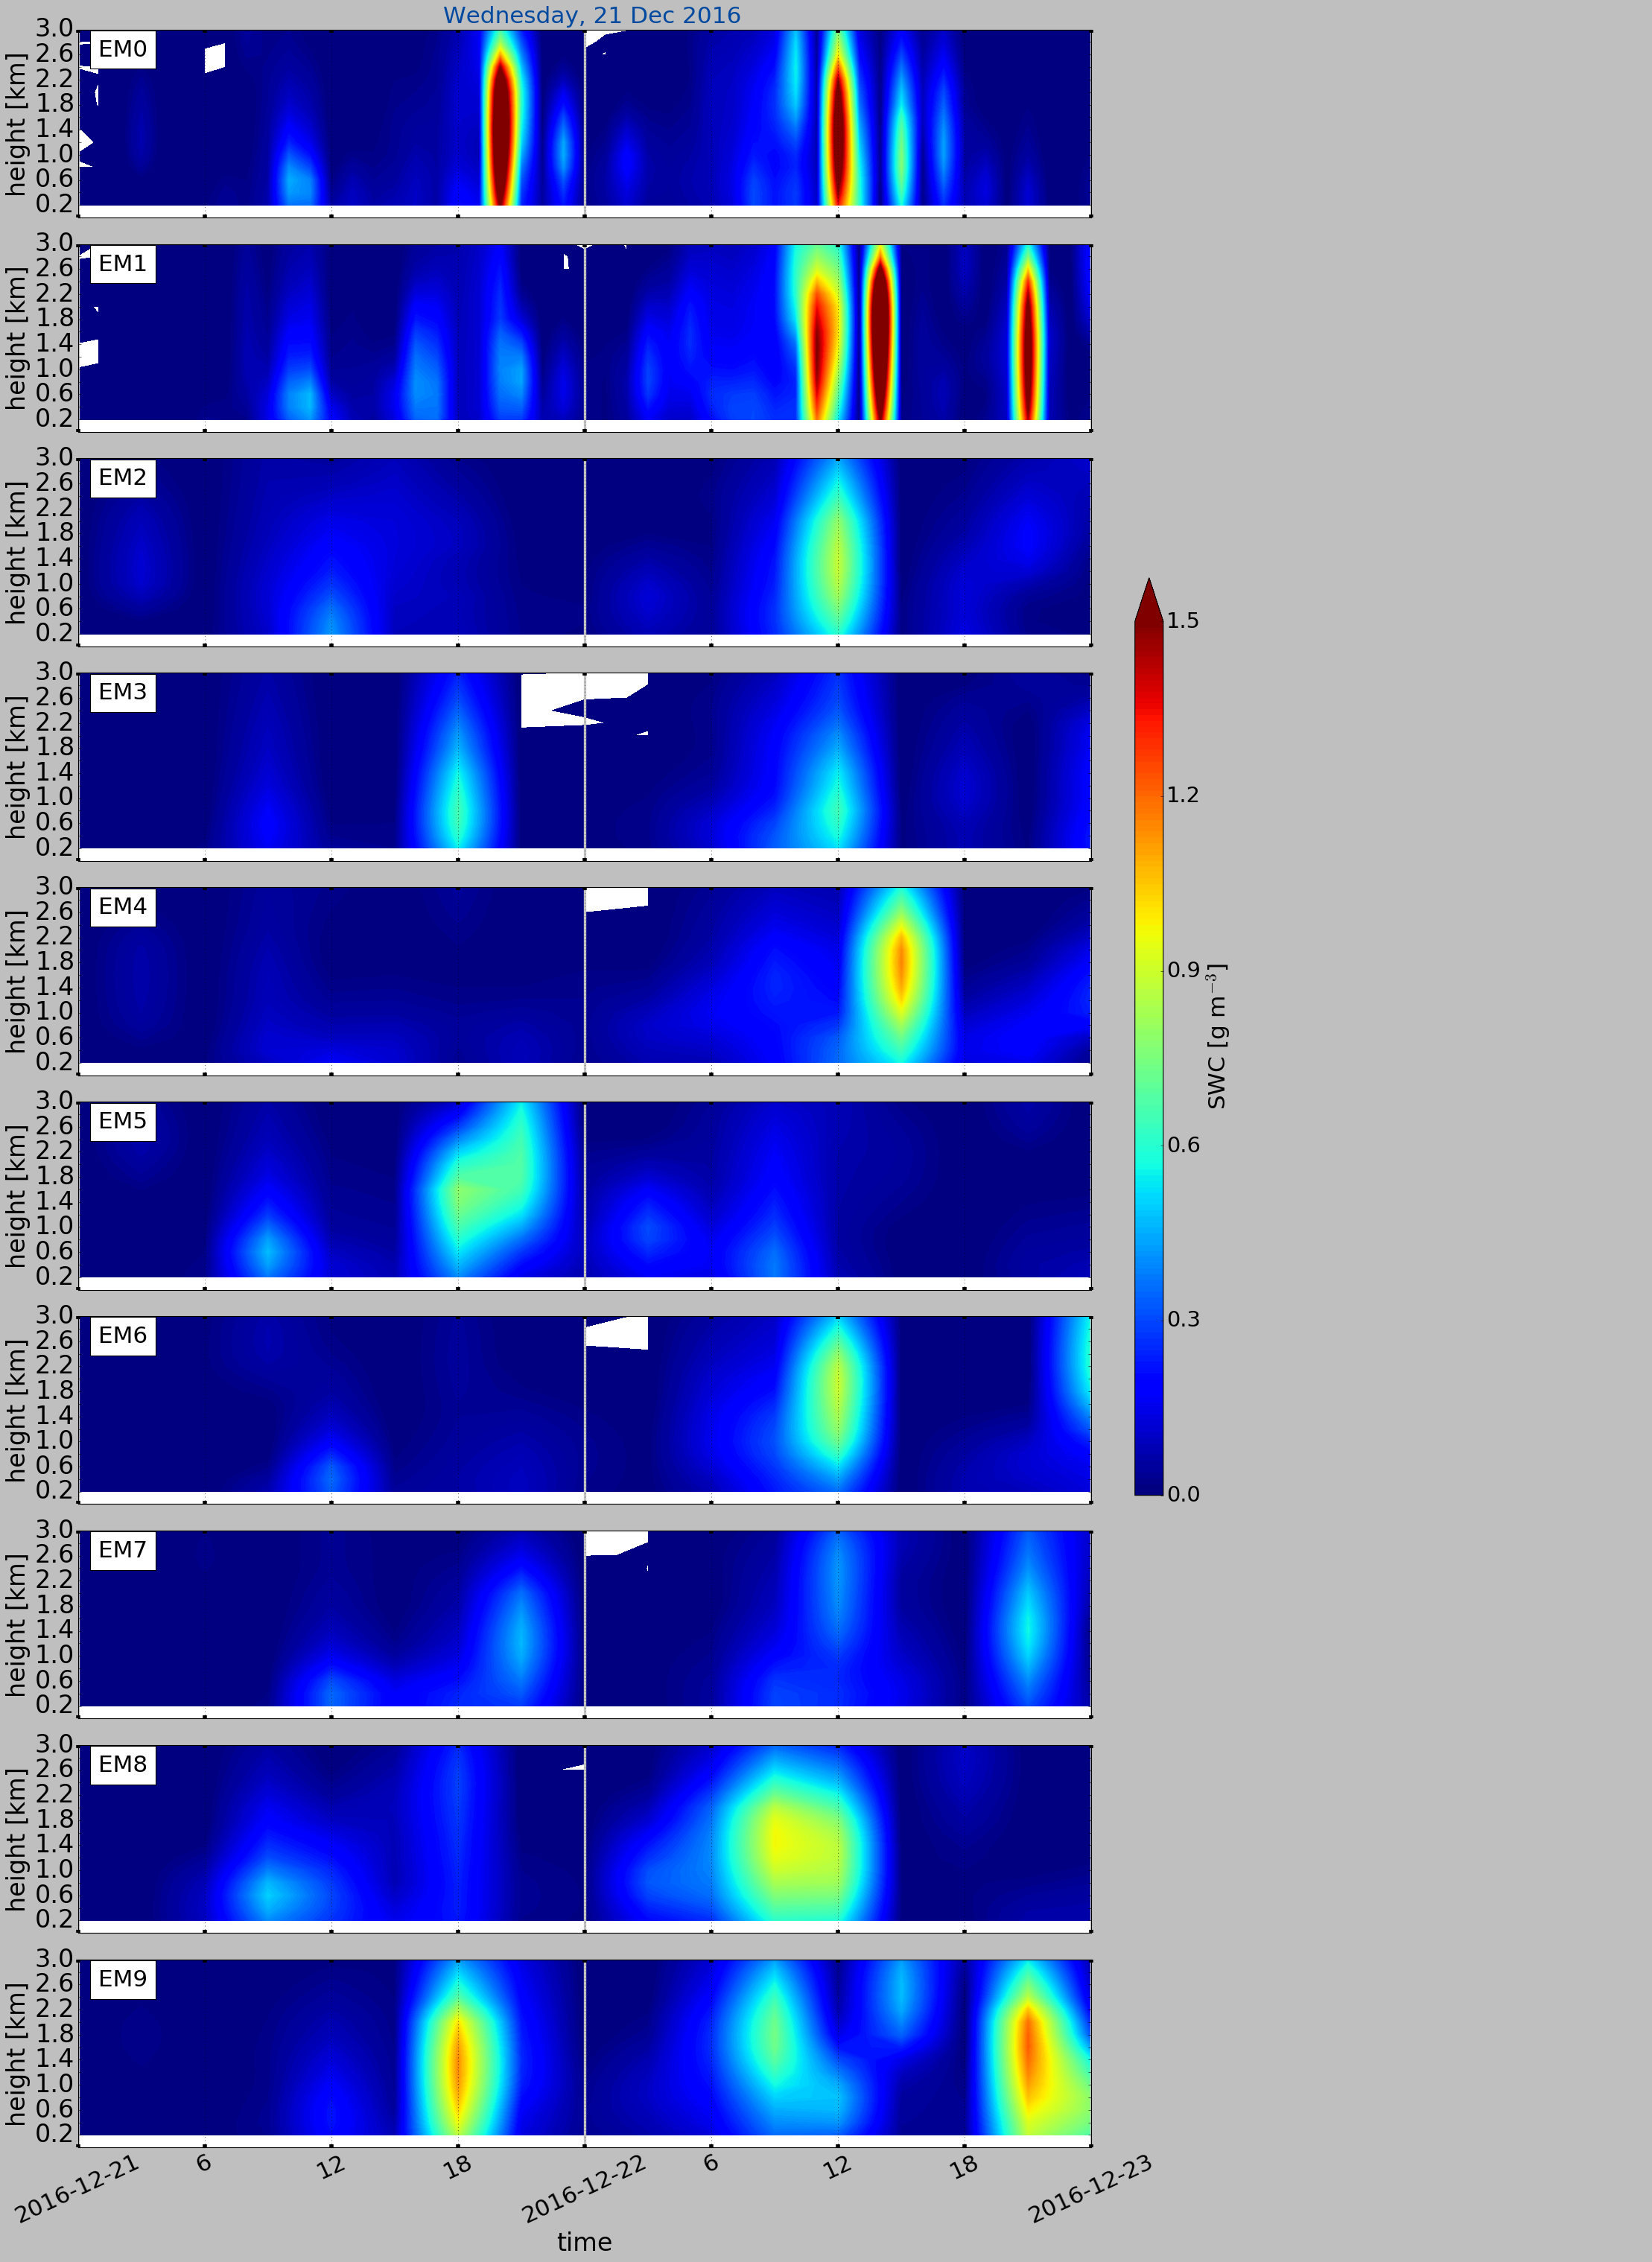

In [6]:
#for k in range(0,np.asarray(t).shape[0]):
for k in range(1,2):
    day = t[k]
## MEPS ######
    for ens_memb in range(0,10):
        air_temp_file[ens_memb]= '%s/%s%s%s_%s_%s.nc' %(air_temp_dir,year,month,day,tid,ens_memb)
        snow_file[ens_memb]    = '%s/%s%s%s_%s_%s.nc' %(snow_dir,year,month,day,tid,ens_memb)
        graupel_file[ens_memb] = '%s/%s%s%s_%s_%s.nc' %(graupel_dir,year,month,day,tid,ens_memb)
        cl_ice_file[ens_memb]  = '%s/%s%s%s_%s_%s.nc' %(cl_ice_dir,year,month,day,tid,ens_memb)
        
        fn_air_temp[ens_memb]  = netCDF4.Dataset(air_temp_file[ens_memb])
        fn_snow[ens_memb]      = netCDF4.Dataset(snow_file[ens_memb])
        fn_graupel[ens_memb]   = netCDF4.Dataset(graupel_file[ens_memb]) 
        fn_cl_ice[ens_memb]    = netCDF4.Dataset(cl_ice_file[ens_memb])

# Read in time to know initialisation time (plotting)    
        time_ml[ens_memb] = fn_snow[ens_memb].variables['time']
        time_ml[ens_memb] = fv.fill_nan(time_ml[ens_memb][:])
        

        ini_day = datetime.datetime.utcfromtimestamp(time_ml[0][0]).day   # day of initialisation
        hh = datetime.datetime.utcfromtimestamp(time_ml[0][0]).hour       # first hour of initialisation?
        calday, calmon = cd.get_dayname(year, month, ini_day)
        
# Read in the pressure, and the air temperature to calculate ice amount from [kg/kg] to [kg/m^3]
        air_temp_ml[ens_memb] = fn_air_temp[ens_memb].variables[var_name_air_temp]
        pressure_ml[ens_memb] = fn_snow[ens_memb].variables['pressure_ml']
# Read in the variable name which should be plotted  
        snow_amount_ml[ens_memb]    = fn_snow[ens_memb].variables[var_name_snow]
        graupel_amount_ml[ens_memb] = fn_graupel[ens_memb].variables[var_name_graupel]
        cl_ice_ml[ens_memb]         = fn_cl_ice[ens_memb].variables[var_name_cl_ice]


# create an array with time of the shape of the variable
        lead_time   = np.arange(0,snow_amount_ml[ens_memb].shape[0])
        model_level = np.arange(0,snow_amount_ml[ens_memb].shape[1])
        td,Y        = np.meshgrid(lead_time,model_level)

# substitute missing values with nan 
        pressure_ml[ens_memb]       = fv.fill_nan(pressure_ml[ens_memb][:])
        air_temp_ml[ens_memb]       = fv.fill_nan(air_temp_ml[ens_memb][:])
        snow_amount_ml[ens_memb]    = fv.fill_nan(snow_amount_ml[ens_memb][:])
        graupel_amount_ml[ens_memb] = fv.fill_nan(graupel_amount_ml[ens_memb][:])
        cl_ice_ml[ens_memb]         = fv.fill_nan(cl_ice_ml[ens_memb][:])
# get ice amount (snow+graupel)
        ice_amount_ml[ens_memb]     = snow_amount_ml[ens_memb] + graupel_amount_ml[ens_memb] + cl_ice_ml[ens_memb]
    
# layer thickness to calculate height
        thickness_ml[ens_memb]      = fn_snow[ens_memb].variables['layer_thickness']
        thickness_ml[ens_memb]      = fv.fill_nan(thickness_ml[ens_memb][:])
    
        thickness = thickness_ml[ens_memb]
        h_above = []
        h_above.append(np.zeros(thickness[:,:].shape[0]))
        th_arr = np.nansum([np.asarray(h_above)[:,0], thickness[:,0]], axis = 0)
        h_above.append(th_arr)
        for i in range(2,thickness[:,:].shape[1]):
            th_arr = np.nansum([h_above[i-1], thickness[:,i-1]], axis = 0)
            h_above.append(th_arr)
        height_ml[ens_memb] = np.transpose(h_above)
        
        

# calculate density at each level
        density_ml[ens_memb] = pressure_ml[ens_memb]/(Rd*air_temp_ml[ens_memb])
        

# convert from [kg/kg] to [kg/m^3]
        ice_amount_ml[ens_memb] = (ice_amount_ml[ens_memb]*density_ml[ens_memb])

# convert the snow amount from [kg/m^2] into [g/m^2] by multiply with 1000
        ice_amount_ml[ens_memb] = (ice_amount_ml[ens_memb]*1000.)

    
# get only valuable values not nan    
        time_ml[ens_memb]       = (time_ml[ens_memb][~np.isnan(time_ml[ens_memb])])
        time[ens_memb]          = (td[:,~np.isnan(ice_amount_ml[ens_memb]).any(axis=1)])
        height[ens_memb]        = (height_ml[ens_memb][~np.isnan(ice_amount_ml[ens_memb]).any(axis=1),:])
        thickness_ml[ens_memb]  = (thickness_ml[ens_memb][~np.isnan(ice_amount_ml[ens_memb]).any(axis=1),:]) 
        air_temp_ml[ens_memb]   = (air_temp_ml[ens_memb][~np.isnan(ice_amount_ml[ens_memb]).any(axis=1),:])
        pressure_ml[ens_memb]   = (pressure_ml[ens_memb][~np.isnan(ice_amount_ml[ens_memb]).any(axis=1),:])
        ice_amount_ml[ens_memb] = (ice_amount_ml[ens_memb][~np.isnan(ice_amount_ml[ens_memb]).any(axis=1)])


# calculate mean of snowfall amount in each layer, every 200m
        SWC_ml = []
        h_mid = []
        for k in range(0, nlay):
            tidx,hidx = np.where(np.logical_and(height_ml[ens_memb][:,:] >= bot[k], height_ml[ens_memb][:,:] < top[k]))
    
    # average in layer
            SWC_ml.append(np.nanmean(ice_amount_ml[ens_memb][:,hidx[:]], axis = 1))
            h_mid.append((bot[k]+top[k])/2)
        avg_SWC_ml[ens_memb] = SWC_ml

        hidx = []
        tidx = []
        for i in range(0,np.asarray(avg_SWC_ml[ens_memb]).shape[1]):
            hidx.append(h_mid)
        h_avg[ens_memb] = hidx
        for i in range(0,np.asarray(avg_SWC_ml[ens_memb]).shape[0]):
            tidx.append(time[ens_memb][0,:])
        t_avg[ens_memb] = tidx

### exclude values above 3km
        h1, h2 = np.where(height[ens_memb][:,:] > 3000)
        ice_amount_ml[ens_memb][h1[:],h2[:]] = np.nan
        time[ens_memb][h2[:],h1[:]]          = -9999
        height[ens_memb][h1[:],h2[:]]        = np.nan
    

###################################################################################

### exclude values smaller than 0.01
#    for ens_memb in range(0,10):
 #       if len(ice_amount_ml[ens_memb]) == 0:
  #          continue
   #     else:
    #        a2,b2 = np.where(ice_amount_ml[ens_memb][:,:] < 0.01)    ## 0.001? retrieved_snowfall_amount = iwcpsd*0.85*e-3*3600*24
     #       ice_amount_ml[ens_memb][a2[:],b2[:]] = np.nan
      #  if len(avg_SWC_ml[ens_memb]) == 0:
       #     continue
        #else:
         #   a3,b3 = np.where(np.asarray(avg_SWC_ml[ens_memb]) < 0.01)
          #  avg_SWC_ml[ens_memb] = np.asarray(avg_SWC_ml[ens_memb])
           # avg_SWC_ml[ens_memb][a3[:],b3[:]] = np.nan
########################################

### PLOTTING ###########
    xdays = ['%s-%s-%s' %(year,month,ini_day), 
        6,12, 18,
        '%s-%s-%s' %(year,month,ini_day+1), 
        6, 12, 18,
        '%s-%s-%s' %(year,month,ini_day+2)]

    fig_name = '%s%s%s.%s' %(year,month,ini_day,form)
    mpl.style.use('classic')
    fig = plt.figure(figsize=(28.,40))

    gs = GridSpec(10,3)
    levels = np.arange(0,1.51,0.01) 
    # title
    fig.suptitle('%s, %s %s %s' %(calday, day, calmon, year),x = 0.36, y=0.95, color =im.date_blue, fontsize = im.fontsize)
## 1st subplot --- 
    for ens_memb in range(0,9):
        if np.size(avg_SWC_ml[ens_memb]) == 0:
            continue
        else:
            ax0 = plt.subplot(gs[ens_memb,:-1])
            # Vertical line to show end of day
            ax0.axvline(0,color = spagh.vert_col, linewidth = 3)
            ax0.axvline(24,color = spagh.vert_col, linewidth = 3)
            ax0.axvline(48,color = spagh.vert_col, linewidth = 3)
            im0 = im.plt_ce_image2(ax0, t_avg[ens_memb], np.transpose(h_avg[ens_memb]), avg_SWC_ml[ens_memb],levels,
                v_min=0.01, v_max=1.5, xmax=48., ymax=3000.,
                xticks=np.arange(0,49,6), yticks=im.yticks1,
                xlabel=xdays)
        ax0.text(0.02,0.95, 'EM%s' %ens_memb ,
            verticalalignment ='top', horizontalalignment='left',
             transform = ax0.transAxes,
             color = 'k', fontsize = im.fontsize,
             bbox={'facecolor':'white','alpha':1.,'pad':10})
        ax0.xaxis.grid()
        
    ax31 = plt.subplot(gs[3,-1])
    cbaxes = fig.add_axes([0.685, .325, 0.017, 0.385])  # [left, bottom, width, height] 
    im.add_colorbar2(fig,ax31, im0, cbaxes, levels[::30], 'SWC [g m$^{-3}$]')
    
    for ens_memb in range(9,10):
        if np.size(avg_SWC_ml[ens_memb]) == 0:
            continue
        else:
            ax0 = plt.subplot(gs[ens_memb,:-1])
            # Vertical line to show end of day
            ax0.axvline(0,color = spagh.vert_col, linewidth = 3)
            ax0.axvline(24,color = spagh.vert_col, linewidth = 3)
            ax0.axvline(48,color = spagh.vert_col, linewidth = 3)
            im0 = im.plt_ce_image(fig,ax0, t_avg[ens_memb], np.transpose(h_avg[ens_memb]), avg_SWC_ml[ens_memb],
                                  levels,
                v_min=0.01, v_max=1.5, xmax=48., ymax=3000.,
                xticks=np.arange(0,49,6), yticks=im.yticks1, cb_ticks = [],
                xlabel=xdays,var_label='',cb=0)
        ax0.text(0.02,0.95, 'EM%s' %ens_memb ,
            verticalalignment ='top', horizontalalignment='left',
             transform = ax0.transAxes,
             color = 'k', fontsize = im.fontsize,
             bbox={'facecolor':'white','alpha':1.,'pad':10})
        ax0.xaxis.grid()
    
    
    
    ################
    plt.tight_layout(pad=1.4, w_pad=1.5, h_pad=1.5)
    fig.subplots_adjust(top=0.94)

    if savefig ==1:
        sF.save_figure_portrait(figdir, fig_name, form)
        print('saved: %s/%s' %(figdir, fig_name))
    else:
        plt.show()
    plt.close()
    
    for ens_memb in range(0,10):
        fn_air_temp[ens_memb].close()
        fn_snow[ens_memb].close()
        fn_graupel[ens_memb].close()
        fn_cl_ice[ens_memb].close()